In [2]:
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

In [4]:
hits = ROOT.TFile.Open('../../ionut/hits_gen.root')
kine = ROOT.TFile.Open('../../ionut/kine_gen.root')
hits_tree = hits.Get("o2sim")
kine_tree = kine.Get("o2sim")

In [5]:
hits_tree.Print()

******************************************************************************
*Tree    :o2sim     : o2sim                                                  *
*Entries :     5328 : Total =          217135 bytes  File  Size =     109663 *
*        :          : Tree compression factor =   1.96                       *
******************************************************************************
*Br    0 :Vx        : Vx/D                                                   *
*Entries :     5328 : Total  Size=      43245 bytes  File Size  =      23768 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.80     *
*............................................................................*
*Br    1 :Vy        : Vy/D                                                   *
*Entries :     5328 : Total  Size=      43245 bytes  File Size  =      24732 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.73     *
*...................................................

In [6]:
kine_tree.Print()

******************************************************************************
*Tree    :o2sim     : o2sim                                                  *
*Entries :    27771 : Total =         1508553 bytes  File  Size =     682090 *
*        :          : Tree compression factor =   2.21                       *
******************************************************************************
*Br    0 :Vx        : Vx/D                                                   *
*Entries :    27771 : Total  Size=     223139 bytes  File Size  =     104840 *
*Baskets :        7 : Basket Size=      32000 bytes  Compression=   2.12     *
*............................................................................*
*Br    1 :Vy        : Vy/D                                                   *
*Entries :    27771 : Total  Size=     223139 bytes  File Size  =     106563 *
*Baskets :        7 : Basket Size=      32000 bytes  Compression=   2.09     *
*...................................................

In [7]:
def read_hits_tree(tree):
    entries = tree.GetEntries()
    npx = np.zeros(entries)
    npy = np.zeros(entries)
    npz = np.zeros(entries)
    npval = np.zeros(entries)
    npsubsystem = np.zeros(entries)
    for i in range(entries):
        tree.GetEntry(i)
        npx[i] = tree.Vx
        npy[i] = tree.Vy
        npz[i] = tree.Vz
        npval[i] = tree.HitValue
        npsubsystem[i] = tree.SubSystem
    return npx, npy, npz, npval, npsubsystem

def read_kine_tree(tree):
    entries = tree.GetEntries()
    npx = np.zeros(entries)
    npy = np.zeros(entries)
    npz = np.zeros(entries)
    npenergy = np.zeros(entries)
    npmother = np.zeros(entries)
    for i in range(entries):
        tree.GetEntry(i)
        npx[i] = tree.Vx
        npy[i] = tree.Vy
        npz[i] = tree.Vz
        npenergy[i] = tree.energy
        npmother[i]= tree.motherTrackId
    return npx, npy, npz, npenergy, npmother



x,y,z,val,subsystem = read_hits_tree(hits_tree)
val = val*1E-6
tx,ty,tz,te,tm = read_kine_tree(kine_tree)

Dimensions should be 996.2×1008×1100mm. Z=1100. 

In [ ]:
points = [0, 1, 2]
xx = [0, 10, 50]
yy = [5, 10, 10]
lines = [[0,1], [0,2], [1,2]]
for l in lines:
    plt.plot(xx[])

# Digitization

A simple first step is just to make a geometry as I have done before and add a fill operation so that I can easily just loop through hits and fill the grids.

Warning and stop when no hit, especially to capture if it hits the center hole.

Dynamically build based on some principles. Width and height, number of fibers per cell? Otherwise use solutions I have used before.

# Geometry

Dimensions should be 996.2×1008×1100mm. Z=1100. With a hole in the center 84x84.

So something like dividing 996.2×1008 into some size. For instance, it seems there should be 4 fibers per cell, and from inspecting some slides from Hadi, the 84mm opening would have ~21 fibers. So 21/4=5.25 cells for every 84mm. So (996.2/84)*5.25?

The issue may be, how do I deal with the center? Can I just take the region of (4.1,4.1), (-4.1,4.1), (-4.1,-4.1) and (-4.1,-4.1) and go from there in 

In [8]:
def horizontal_cells():
    width = 996.2
    opening = 84
    cells_per_opening = 21/4
    print("width:", width, ", opening:", opening, ", cells per opening:", cells_per_opening)
    print("cell width:", opening/cells_per_opening)
    print("cells:", width/(opening/cells_per_opening))


horizontal_cells()

width: 996.2 , opening: 84 , cells per opening: 5.25
cell width: 16.0
cells: 62.2625


In [9]:
def vertical_cells():
    height = 1008
    opening = 84
    cells_per_opening = 24/4
    print("height:", height, ", opening:", opening, ", cells per opening:", cells_per_opening)
    print("cell width:", opening/cells_per_opening)
    print("cells:", height/(opening/cells_per_opening))

vertical_cells()

height: 1008 , opening: 84 , cells per opening: 6.0
cell width: 14.0
cells: 72.0


It's gonna be divided into awkward modules. Something like almost-halves top and bottom, and slices left and right of opening.

**Upper**

y = 1008/2, 84/2
x = -996.2/2, 996.2/2

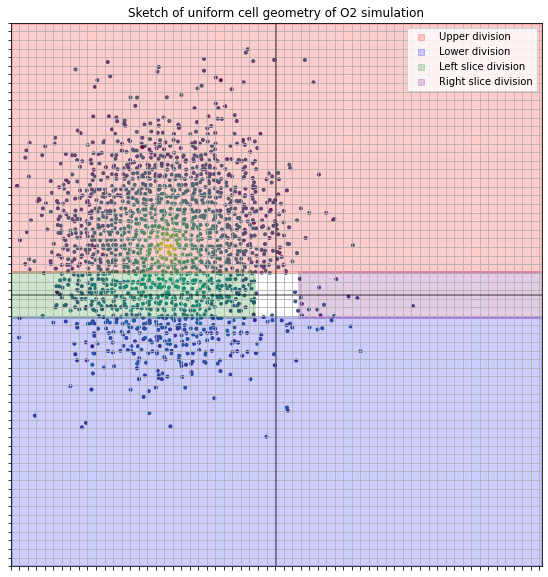

In [10]:
focmask = subsystem == 2


colors = np.log(val[focmask]) / (np.log(val[focmask]).max()/1)
#colors = np.random.rand(val.shape[0])

width = 996.2*1E-1
height = 1008*1E-1
opening = 84*1E-1

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(-width/2, width/2)
ax.set_ylim(-height/2, height/2)

ax.scatter(x[focmask],y[focmask],marker=".",c=colors, cmap='viridis')

upper = patches.Rectangle((-width/2, opening/2), width, height/2-opening/2, linewidth=3, edgecolor='red', facecolor='red', alpha=0.2)
lower = patches.Rectangle((-width/2, -opening/2), width, -height/2+opening/2, linewidth=3, edgecolor='blue', facecolor='blue', alpha=0.2)
left = patches.Rectangle((-width/2, -opening/2), width/2-opening/2, opening, linewidth=3, edgecolor='green', facecolor='green', alpha=0.2)
right = patches.Rectangle((opening/2, -opening/2), width/2-opening/2, opening, linewidth=3, edgecolor='purple', facecolor='purple', alpha=0.2)


# Add the patch to the Axes
ax.add_patch(upper)
ax.add_patch(lower)
ax.add_patch(left)
ax.add_patch(right)
ax.set_aspect(1008/996.2)



# Set grid lines frequency
#grid_interval = 1.6
#ax.xaxis.set_major_locator(ticker.MultipleLocator(grid_interval))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(grid_interval))
#ax.grid(True, which='both')



ax.set_xticks(np.arange(-width/2, width/2, 1.6))
ax.set_yticks(np.arange(-height/2, height/2., 1.6))
_ = ax.set_xticklabels([])
_ = ax.set_yticklabels([])
plt.grid()


ax.scatter([],[], marker="s", label="Upper division", color="red", alpha=0.2)
ax.scatter([],[], marker="s", label="Lower division", color="blue", alpha=0.2)
ax.scatter([],[], marker="s", label="Left slice division", color="green", alpha=0.2)
ax.scatter([],[], marker="s", label="Right slice division", color="purple", alpha=0.2)
ax.legend()

ax.set_title("Sketch of uniform cell geometry of O2 simulation")

#ax.grid(False, which="major")

ax.axvline(0, color="black", alpha=0.5)
ax.axhline(0, color="black", alpha=0.5)

fig.savefig("rough_geo.svg", bbox_inches="tight")



In [11]:
12*5+2

62

In [12]:
12*5+3

63

In [13]:
def search(p, x, y):
    for i, path in enumerate(p):
        if path.contains_point((x,y)):
            return i
    print("Coordinates not within any polygon!")
    return -1



width = 996.2*1E-1
height = 1008*1E-1
opening = 84*1E-1

cells_x = 62
cells_y = 63

w=width/cells_x
h=height/cells_y

X = np.arange(-width/2 + w/2, width/2 - w/2, width/cells_x)
Y = np.arange(-height/2 + h/2, height/2 - h/2, height/cells_y)
XY = np.meshgrid(X,Y)


#_ = ax.set_xlim(-width/2, width/2)
#_ = ax.set_ylim(-height/2, height/2)


polygons = []

# Run over flatten.
opening_mask = (np.abs(XY[0]) <= 4.2) & (np.abs(XY[1]) <= 4.2)
Xf = XY[0][~opening_mask].flatten()
Yf = XY[1][~opening_mask].flatten()

for i in range(len(Xf)):
    if i not in (0,5,10, 250):
        pass
    polygons.append(Polygon([(Xf[i]-w/2,Yf[i] -h/2), (Xf[i]-w/2,Yf[i] +h/2), (Xf[i]+w/2,Yf[i] +h/2), (Xf[i]+w/2,Yf[i] -h/2)]))

digits = np.zeros(len(polygons))
paths = [polygon.get_path() for polygon in polygons]

print("searching")
for i in range(len(val[focmask])):
    idx = search(paths,x[i],y[i])
    if idx!=-1:
        digits[idx] += val[i]
    else:
        print("No hit")
        continue
print("searched")

    

c = np.zeros(len(polygons) * 4).reshape(len(polygons), 4)
    





#c[search(paths,0,0)] = (1,0,0,0)
#c[search(paths,0,0)] = (1,0,0,0)





searching
searched


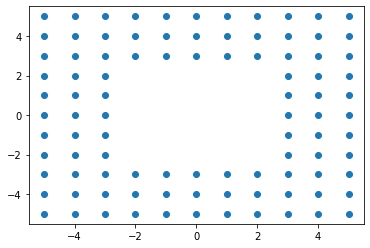

In [212]:
mesh_test = np.meshgrid(xtest, ytest)
mask = (np.abs(mesh_test[0]) <= 2) & (np.abs(mesh_test[1]) <= 2)

plt.scatter(mesh_test[0][~mask].flatten(), mesh_test[1][~mask].flatten())

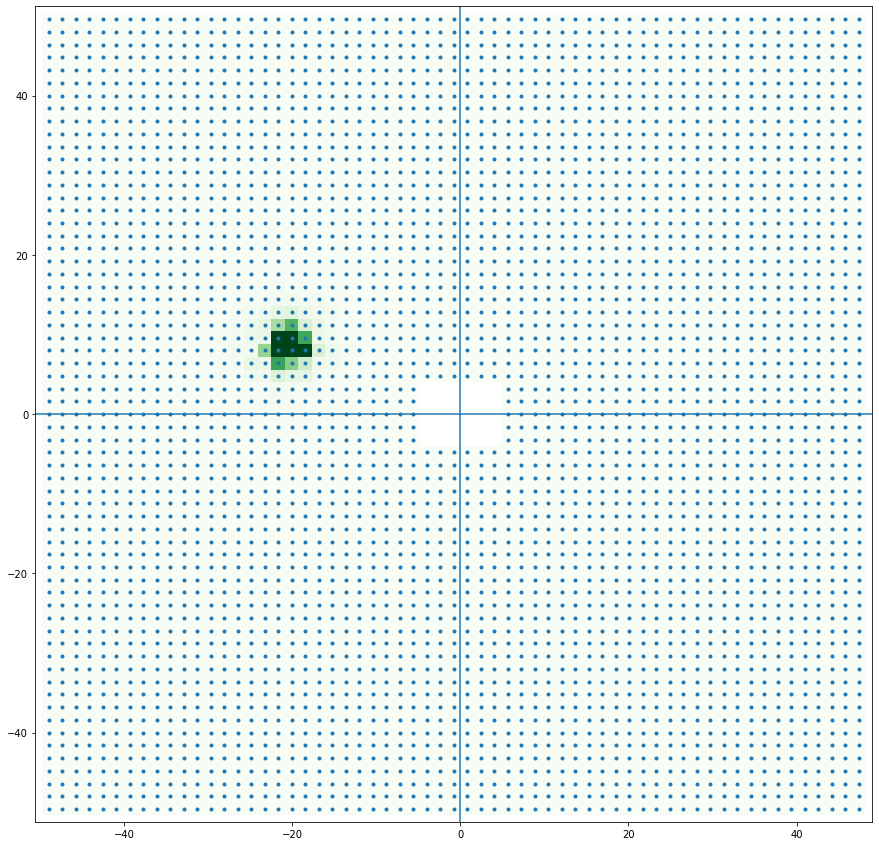

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
patches = PatchCollection(polygons, alpha=1)
patches.set_facecolor(c)
#patches.set_clim(0, 4096)|
#c[0]=(1,0,0,0)

norm = Normalize(vmin=0, vmax=4096)

for i in range(len(c)):
#    c[i] = plt.colormaps["Greens"](norm(digits[i]))
    c[i] = plt.colormaps["Greens"](norm(digits[i]))


ax.add_collection(patches)
#fig.colorbar(digits)
_ = ax.set_xlim(-width/2-w/2, width/2-w/2)
_ = ax.set_ylim(-height/2-h/2, height/2+h/2)

plt.scatter(Xf, Yf, marker=".")
plt.axvline(0)
plt.axhline(0)

In [250]:
norm(digits).max()

90768.01942905717

In [159]:
digits.max()

90805.11093428703

In [186]:
val.shape

(5328,)

In [187]:
val[focmask].shape

(1639,)

In [154]:
c.shape
#digits.shape
len(paths)

3843

In [139]:
plt.colormaps["Greens"](norm(digits[0]))

(0.9686274509803922, 0.9882352941176471, 0.9607843137254902, 1.0)

In [77]:
paths[digits != 0]

TypeError: only integer scalar arrays can be converted to a scalar index

(array([21.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  944.225856 ,  3402.9473856,  5861.6689152,  8320.3904448,
        10779.1119744, 13237.833504 , 15696.5550336, 18155.2765632,
        20613.9980928, 23072.7196224, 25531.441152 ]),
 <BarContainer object of 10 artists>)

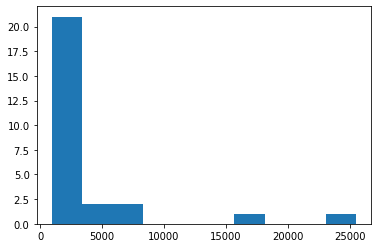

In [140]:
plt.hist(np.sort(val)[5300:-1])

In [98]:
val

array([  542901.      ,  4112773.25    , 12623386.      , ...,
         295120.0625  ,   158772.890625,   276519.25    ])

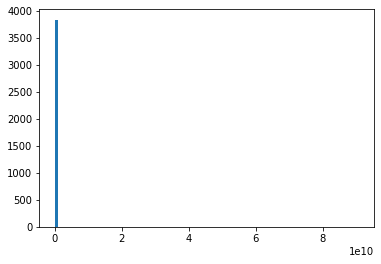

In [67]:
_ = plt.hist(digits, bins=100)

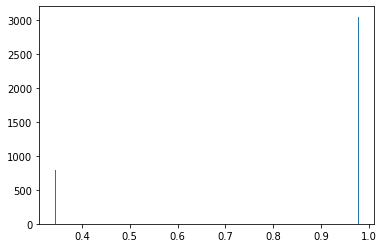

In [82]:
digits
_ = plt.hist(plt.colormaps["Greens"](norm(digits)).mean(axis=1), bins=200)

In [69]:
val.min()

22.168174743652344

In [55]:
lst = [0]*10
lst

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

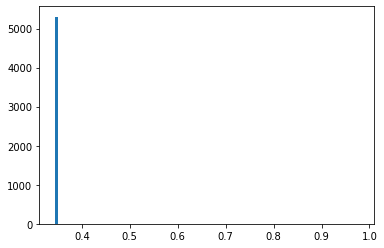

In [45]:
norm = Normalize(vmin=0, vmax=4096)
_ = plt.hist(plt.colormaps["Greens"](norm(val)).mean(axis=1), bins=100)

In [50]:
plt.colormaps["Greens"](norm(val)).mean(axis=1).max()

0.9779969242599

In [42]:
val[val < 1E3].shape

(9,)

In [39]:
val.max()

58846666752.0

In [40]:
norm(val).max()

14366862.0

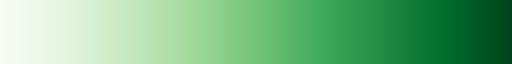

In [16]:
plt.colormaps["Greens"]

In [41]:
np.arange(1,10,1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
np.linspace(1,10,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [265]:
X.shape

(62,)

In [266]:
XY[0].shape

(64, 62)

In [218]:
12*5+2

62

In [219]:
12*5+3

63